In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# 1. Installation des packages requis

# 2. Téléchargement des données de Commodities
On récupère les données de 5 commodities : Crude Oil, Natural Gas, Gold, Silver, Copper

In [20]:
# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F

commodities_tickers = ["CL=F", "NG=F", "GC=F", "SI=F", "HG=F"]

def get_commodities_data(tickers, start="2010-01-01", end="2023-01-01", interval="1d"):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end, interval=interval)
        data[ticker] = df
    return data

commodities_data = get_commodities_data(commodities_tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [21]:
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

training_data = {}
validation_data = {}
test_data = {}

for ticker, df in commodities_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]].copy()
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]].copy()
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]].copy()

# Exemple d'affichage pour le ticker GC=F (Gold)
print("Training data shape for GC=F:", training_data["GC=F"].shape)
print("Validation data shape for GC=F:", validation_data["GC=F"].shape)
print("Test data shape for GC=F:", test_data["GC=F"].shape)

Training data shape for GC=F: (2011, 5)
Validation data shape for GC=F: (502, 5)
Test data shape for GC=F: (756, 5)


- Training : from 2010-01-01 to 2017-12-31  
- Validation : from 2018-01-01 to 2019-12-31  
- Test : from 2020-01-01 to 2023-01-01

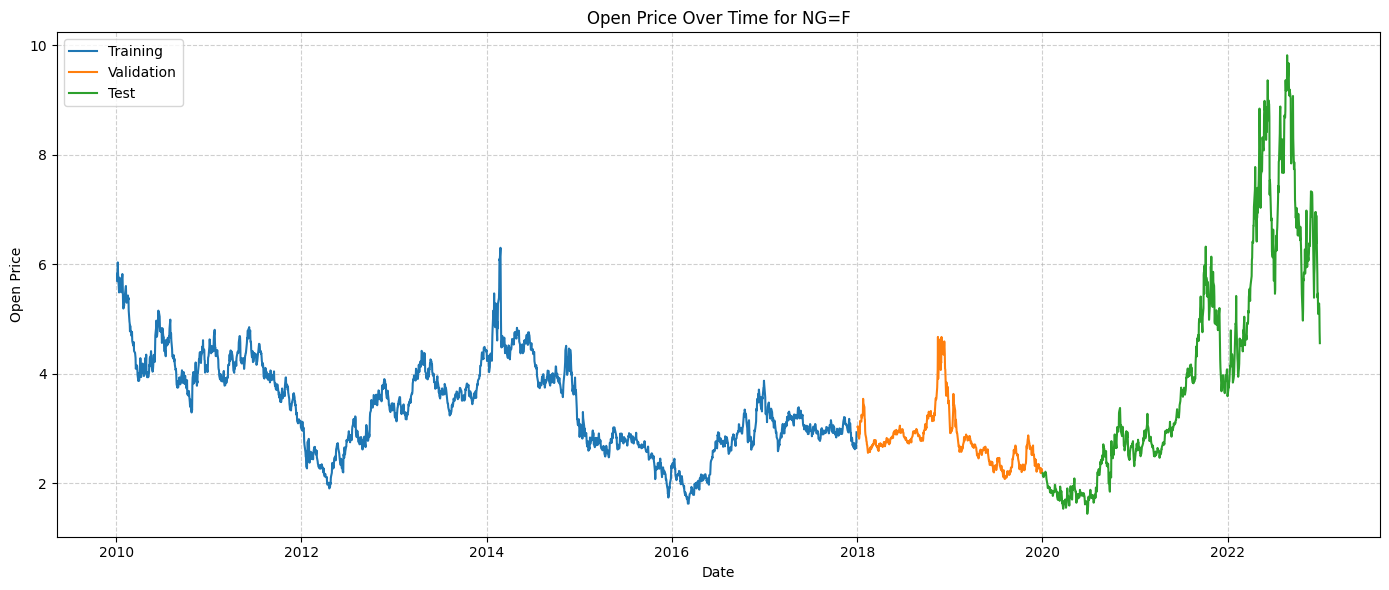

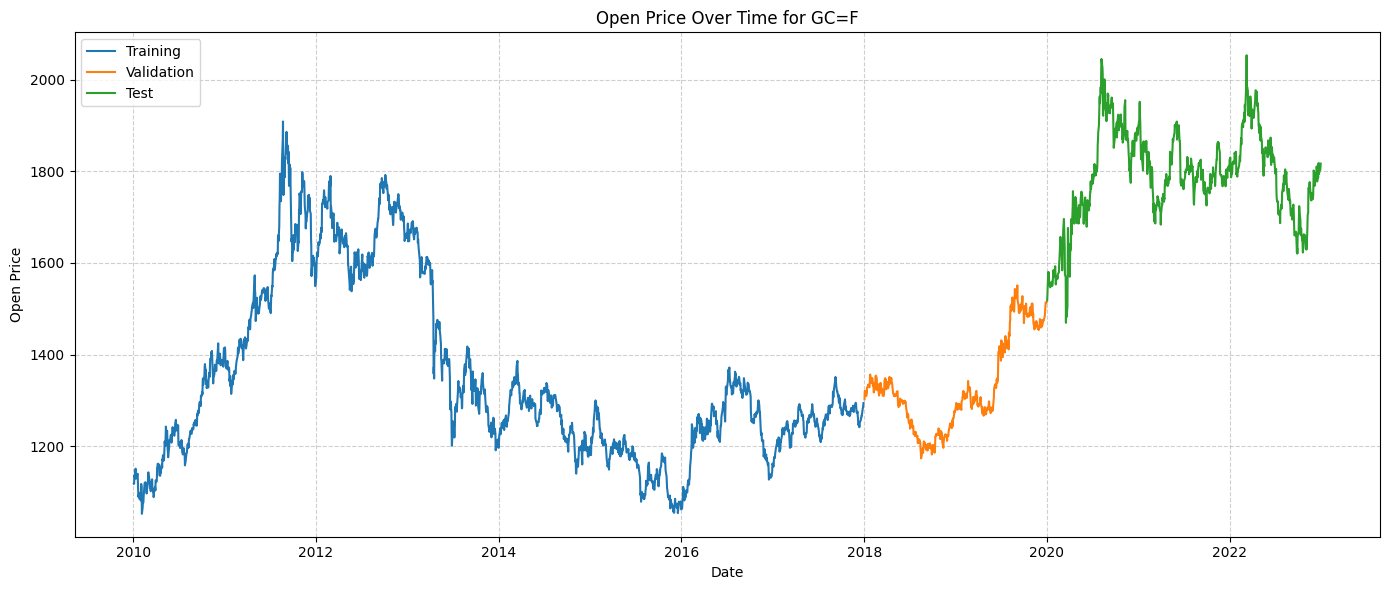

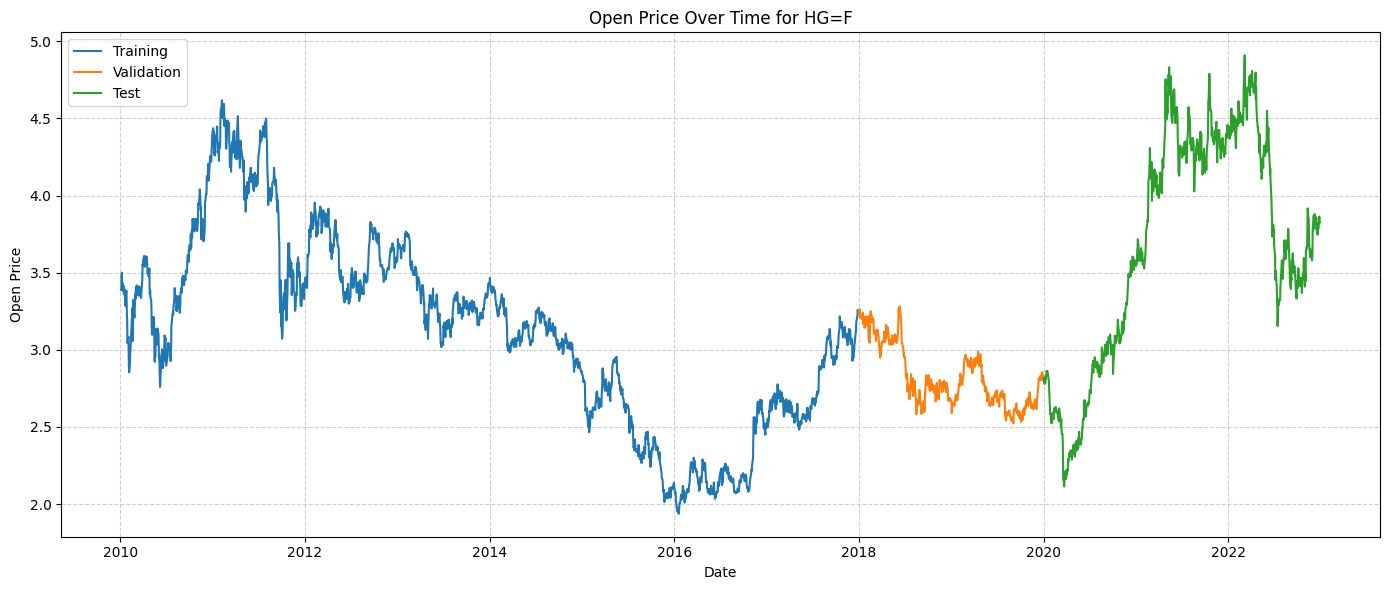

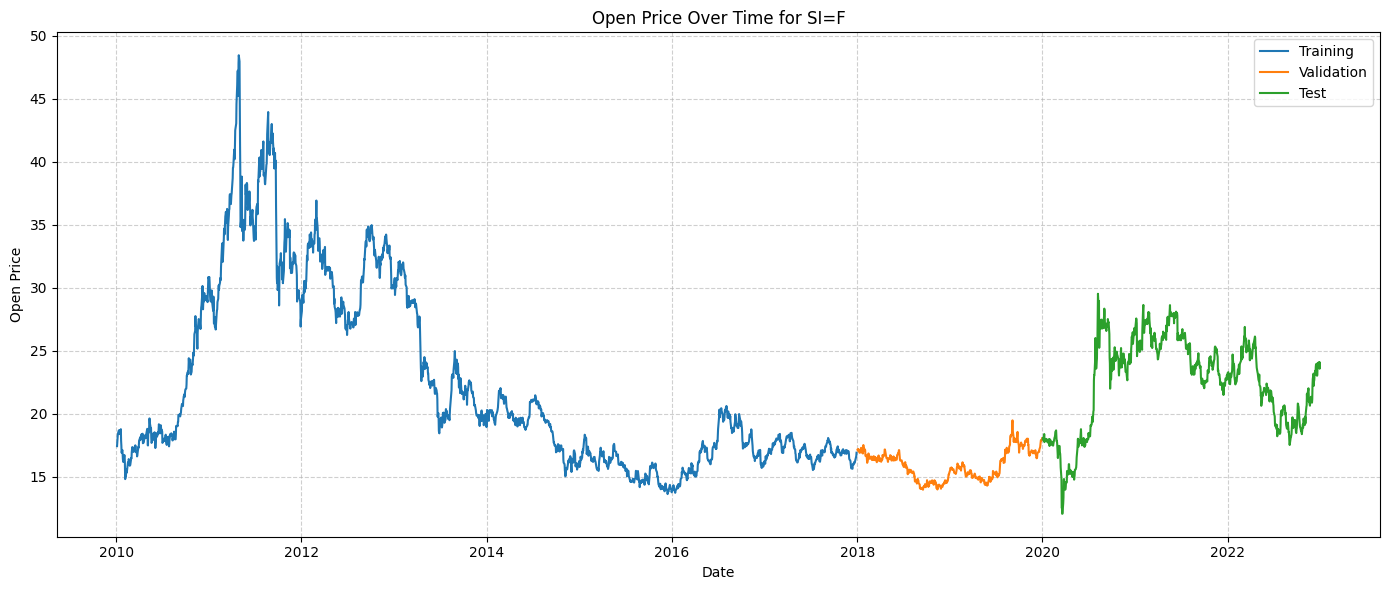

In [22]:
import matplotlib.pyplot as plt

def plot_open_price(tickers, training_data, validation_data, test_data):

    if isinstance(tickers, str):
        tickers = [tickers]
    
    for ticker in tickers:
        plt.figure(figsize=(14, 6))

        plt.plot(training_data[ticker]['Open'], label='Training', color='#1f77b4')  
        plt.plot(validation_data[ticker]['Open'], label='Validation', color='#ff7f0e') 
        plt.plot(test_data[ticker]['Open'], label='Test', color='#2ca02c')      

        plt.title(f'Open Price Over Time for {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Open Price')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

plot_open_price([ "NG=F", "GC=F", "HG=F", "SI=F"], training_data, validation_data, test_data)


# 4. Ajout d'indicateurs techniques
On ajoute RSI, MACD, CCI, ADX, etc.

In [23]:
import numpy as np

def add_technical_indicators(df):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)

    high_diff = df['High'].diff()
    low_diff = df['Low'].diff()
    df['+DM'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    df['-DM'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    tr = pd.concat([df['High'] - df['Low'], 
                    np.abs(df['High'] - df['Close'].shift(1)), 
                    np.abs(df['Low'] - df['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.ewm(span=14, adjust=False).mean()
    df['+DI'] = 100 * (df['+DM'].ewm(span=14, adjust=False).mean() / atr)
    df['-DI'] = 100 * (df['-DM'].ewm(span=14, adjust=False).mean() / atr)
    dx = 100 * np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
    df['ADX'] = dx.ewm(span=14, adjust=False).mean()
    
    df.dropna(inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]
    return df

for ticker, df in training_data.items():
    training_data[ticker] = add_technical_indicators(df)
for ticker, df in validation_data.items():
    validation_data[ticker] = add_technical_indicators(df)
for ticker, df in test_data.items():
    test_data[ticker] = add_technical_indicators(df)

print(training_data["GC=F"].head())

Price              Open         High          Low        Close Volume  \
Ticker             GC=F         GC=F         GC=F         GC=F   GC=F   
Date                                                                    
2010-02-01  1081.000000  1107.300049  1076.800049  1104.300049   2452   
2010-02-02  1117.400024  1118.500000  1100.199951  1117.400024   3326   
2010-02-03  1115.800049  1124.900024  1108.599976  1111.400024    853   
2010-02-04  1110.000000  1110.699951  1059.000000  1062.400024   1426   
2010-02-05  1052.199951  1068.500000  1045.199951  1052.199951   1956   

Price            MACD    Signal        RSI         CCI        ADX  
Ticker                                                             
Date                                                               
2010-02-01  -8.662289 -5.106665  34.836633  -65.366222  28.495614  
2010-02-02  -6.795084 -5.444349  46.015247  -10.964782  26.065814  
2010-02-03  -5.733371 -5.502153  41.246502   -0.115025  25.602020  
2010-02

# 5. Création de l'environnement de trading pour Commodities
Nous adaptons l'environnement Gym pour gérer un portefeuille multi-actifs.
Cet environnement gère :  
- un solde initial  
- la détention de positions pour chaque commodity  
- des frais de transaction  
- le calcul de la "net worth" qui est la somme du solde et de la valeur latente des positions

In [24]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class CommodityTradingEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, commodity_data, transaction_cost_percent=0.005, initial_balance=10000):
        super(CommodityTradingEnv, self).__init__()
        
        # Filtrer les DataFrames vides
        self.commodity_data = {ticker: df for ticker, df in commodity_data.items() if not df.empty}
        self.tickers = list(self.commodity_data.keys())
        if not self.tickers:
            raise ValueError("Aucune donnée disponible pour les commodities.")
        
        # Nombre de caractéristiques par actif (par exemple Open, High, Low, Close, Volume, MACD, Signal, RSI, CCI, ADX)
        sample_df = next(iter(self.commodity_data.values()))
        self.n_features = len(sample_df.columns)
        
        # Définir l'espace d'action : continu, un pour chaque actif, dans [-1,1]
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)
        
        # Définir l'espace d'observation : pour chaque actif on prend ses données + balance, shares held, net worth, max net worth, current step
        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)
        
        # Initialisation du portefeuille
        self.initial_balance = initial_balance 
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        
        # Etape courante
        self.current_step = 0
        
        # Nombre maximum d'étapes (basé sur la plus courte série temporelle)
        self.max_steps = max(0, min(len(df) for df in self.commodity_data.values()) - 1)
        
        # Frais de transaction
        self.transaction_cost_percent = transaction_cost_percent
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0
        return self._next_observation(), {}
    
    def _next_observation(self):
        # Initialisation du vecteur observation
        frame = np.zeros(self.obs_shape)
        idx = 0
        for ticker in self.tickers:
            df = self.commodity_data[ticker]
            # On prend les données de la step courante (ou la dernière si terminé)
            if self.current_step < len(df):
                frame[idx:idx+self.n_features] = df.iloc[self.current_step].values
            else:
                frame[idx:idx+self.n_features] = df.iloc[-1].values
            idx += self.n_features
        
        # Ajout de la balance, des positions détenues, du net worth, du max net worth et de la step
        frame[-4-len(self.tickers)] = self.balance
        frame[-3-len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]
        frame[-3] = self.net_worth
        frame[-2] = self.max_net_worth
        frame[-1] = self.current_step
        
        return frame
    
    def step(self, actions):
        # Passer à l'étape suivante
        self.current_step += 1
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        current_prices = {}
        for i, ticker in enumerate(self.tickers):
            # Convertir en float pour être sûr d'obtenir un scalaire
            current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])
            action = actions[i]

            if action > 0:  # Acheter
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                cost = shares_to_buy * current_prices[ticker]
                transaction_cost = cost * self.transaction_cost_percent
                self.balance -= (cost + transaction_cost)
                self.shares_held[ticker] += shares_to_buy
            elif action < 0:  # Vendre
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                sale = shares_to_sell * current_prices[ticker]
                transaction_cost = sale * self.transaction_cost_percent
                self.balance += (sale - transaction_cost)
                self.shares_held[ticker] -= shares_to_sell
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale

        # Calcul du net worth
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        reward = self.net_worth - self.initial_balance
        done = self.net_worth <= 0 or self.current_step >= self.max_steps

        return self._next_observation(), reward, done, False, {}

    
    def render(self, mode='human'):
        profit = self.net_worth - self.initial_balance
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        for ticker in self.tickers:
            print(f"{ticker} Shares held: {self.shares_held[ticker]}")
        print(f"Net worth: {self.net_worth:.2f} | Profit: {profit:.2f}")
    
    def close(self):
        pass

# 6. Définition des Agents avec Stable Baselines3
On définit ici 5 agents : PPO, A2C, DDPG, SAC, TD3 ainsi qu'un agent ensembliste

In [25]:
from stable_baselines3 import A2C, DDPG, SAC, TD3, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

# Agent ensembliste qui combine les prédictions des 5 agents (moyenne)
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model
    
    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        sac_action, _ = self.sac_model.predict(obs)
        td3_action, _ = self.td3_model.predict(obs)
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action

# Pour chacun des agents, on crée une classe wrapper
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

class SACAgent:
    def __init__(self, env, total_timesteps):
        self.model = SAC("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

class TD3Agent:
    def __init__(self, env, total_timesteps):
        self.model = TD3("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)
    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# 7. Entraînement des Agents sur le Trading Multi-Actifs de Commodities
Nous utilisons DummyVecEnv pour encapsuler l'environnement et entraînons chacun des agents

In [26]:
def create_env_and_train_agents(data, total_timesteps):
    env = DummyVecEnv([lambda: CommodityTradingEnv(data, transaction_cost_percent=0.005)])
    
    ppo_agent = PPOAgent(env, total_timesteps)
    a2c_agent = A2CAgent(env, total_timesteps)
    ddpg_agent = DDPGAgent(env, total_timesteps)
    sac_agent = SACAgent(env, total_timesteps)
    td3_agent = TD3Agent(env, total_timesteps)
    
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)
    
    return env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent

# Choix du nombre total de timesteps pour l'entraînement
total_timesteps = 1000
env_train, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent = create_env_and_train_agents(training_data, total_timesteps)

Using cuda device


/home/marius/envs/main_venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])


-----------------------------
| time/              |      |
|    fps             | 750  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
Using cuda device


/home/marius/envs/main_venv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-------------------------------------
| time/                 |           |
|    fps                | 568       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.18     |
|    explained_variance | -2.98e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -7.86e+04 |
|    std                | 1.02      |
|    value_loss         | 2.36e+08  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 570       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.19     |
|    explained_variance | -1.19e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_

# 8. Fonctions de Visualisation et d'Évaluation
Nous définissons des fonctions pour tester un agent, tracer l'évolution du portefeuille (balance, net worth, positions),
et comparer les performances (returns, Sharpe ratio, etc.)

In [27]:
import matplotlib.pyplot as plt

def test_agent(env, agent, data, n_tests=1000, visualize=False):
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in data.keys()}
    }
    
    obs = env.reset()
    
    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, reward, dones, infos = env.step(action)
        if visualize:
            env.render()
        
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares = env.get_attr('shares_held')[0]
        for ticker in data.keys():
            metrics['shares_held'][ticker].append(env_shares.get(ticker, 0))
        if dones:
            obs = env.reset()
    
    return metrics

def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0, start_date="2020-01-01", freq='D'):
    import pandas as pd
    returns, stds, sharpe_ratios = [], [], []

    for metrics in agents_metrics:
        net_worths = metrics['net_worths']
        daily_returns = np.diff(net_worths) / net_worths[:-1]
        avg_return = np.mean(daily_returns)
        std_return = np.std(daily_returns)
        sharpe = (avg_return - risk_free_rate) / (std_return + 1e-9)
        returns.append(avg_return)
        stds.append(std_return)
        sharpe_ratios.append(sharpe)

    df = pd.DataFrame({
        'Agent': labels,
        'Return': returns,
        'Std': stds,
        'Sharpe Ratio': sharpe_ratios
    })
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)
    display(df_sorted)

    # Affichage avec dates sur l'axe x
    steps = range(len(agents_metrics[0]['net_worths']))
    dates = pd.date_range(start=start_date, periods=len(steps), freq=freq)

    plt.figure(figsize=(12, 6))
    for i, metrics in enumerate(agents_metrics):
        plt.plot(dates, metrics['net_worths'], label=labels[i])
    
    plt.title('Net Worth Over Time')
    plt.xlabel('Date')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # Sharpe Ratio bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.grid(True)
    plt.show()


# 9. Test et Visualisation sur les données de Test
On évalue ensuite les agents sur le jeu de test

Testing PPO Agent...


/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing SAC Agent...
Done testing SAC Agent!
Testing TD3 Agent...
Done testing TD3 Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!


,Agent,Return,Std,Sharpe Ratio
3,SAC Agent,0.017791,0.259268,0.068620
2,DDPG Agent,0.017791,0.259268,0.068620
5,Ensemble Agent,0.008013,0.238187,0.033641
1,A2C Agent,0.002613,0.097836,0.026709
0,PPO Agent,0.003407,0.181744,0.018748
4,TD3 Agent,0.000214,0.013032,0.016450


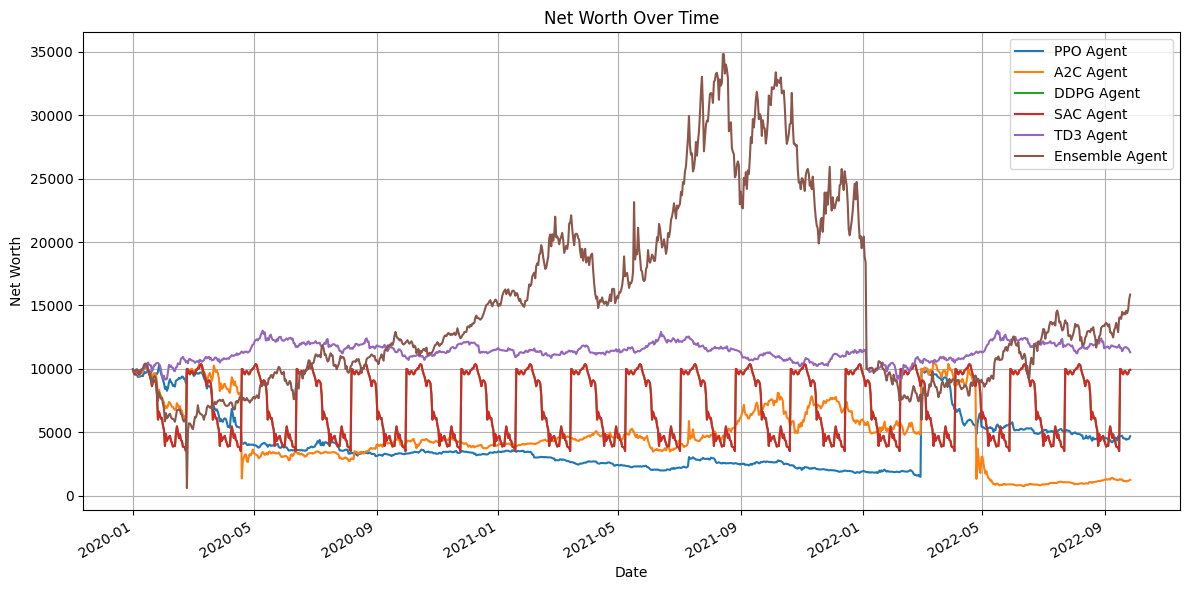

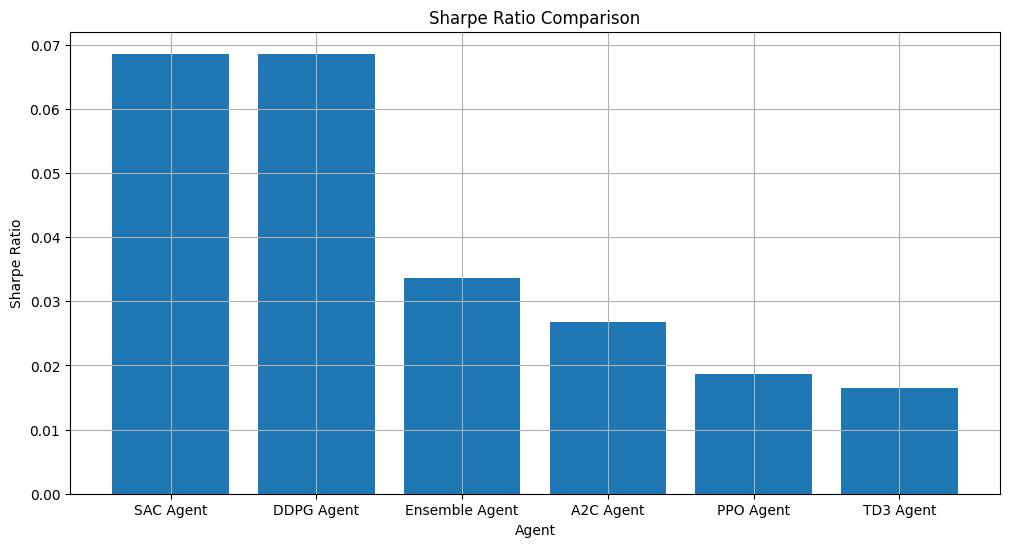

In [28]:
from stable_baselines3.common.vec_env import DummyVecEnv

# Création de l'environnement de test
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, transaction_cost_percent=0.005)])

n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent,
    'Ensemble Agent': ensemble_agent
}

def test_and_visualize_agents(env, agents, data, n_tests=1000):
    metrics = {}
    for name, agent in agents.items():
        print(f"Testing {name}...")
        metrics[name] = test_agent(env, agent, data, n_tests=n_tests, visualize=False)
        print(f"Done testing {name}!")
    steps = next(iter(metrics.values()))['steps']
    net_worths = [metrics[name]['net_worths'] for name in agents.keys()]
    return metrics

test_metrics = test_and_visualize_agents(env_test, agents, test_data, n_tests=1000)
compare_and_plot_agents(list(test_metrics.values()), list(test_metrics.keys()))

In [11]:
import DDPG
import importlib
importlib.reload(DDPG)
from DDPG import DDPGAgent

env = CommodityTradingEnv(commodity_data=training_data)

# Dimensions de l'espace d'observation et d'action
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

# Instanciation de l'agent DDPG
agent = DDPGAgent(env, state_dim, action_dim)

# Entraînement de l'agent sur un certain nombre d'épisodes
rewards = agent.train(num_episodes=50, max_steps_per_episode=env.max_steps, noise_scale=0.)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])


New ddpg agent saved - reward = 6690520.134994105
Episode 1/50 - Reward: 6690520.13
Episode 2/50 - Reward: 4341629.63
Episode 3/50 - Reward: 4341629.63
Episode 4/50 - Reward: 4341629.63
Episode 5/50 - Reward: 4341629.63
Episode 6/50 - Reward: 4341629.63
Episode 7/50 - Reward: 4341629.63
Episode 8/50 - Reward: 4341629.63
Episode 9/50 - Reward: 4341629.63
Episode 10/50 - Reward: 4341629.63
Episode 11/50 - Reward: 4341629.63
Episode 12/50 - Reward: 4341629.63
Episode 13/50 - Reward: 4341629.63
Episode 14/50 - Reward: 4341629.63
Episode 15/50 - Reward: 4341629.63
Episode 16/50 - Reward: 4341629.63
Episode 17/50 - Reward: 4341629.63
Episode 18/50 - Reward: 4341629.63
Episode 19/50 - Reward: 4341629.63
Episode 20/50 - Reward: 4341629.63
Episode 21/50 - Reward: 4341629.63
Episode 22/50 - Reward: 4341629.63
Episode 23/50 - Reward: 4341629.63
Episode 24/50 - Reward: 4341629.63
Episode 25/50 - Reward: 4341629.63
Episode 26/50 - Reward: 4341629.63
Episode 27/50 - Reward: 4341629.63
Episode 28/50 

Training:   0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])


New ddpg agent saved - reward = 2552570.0146208457
Episode 1/1 - Reward: 2552570.01


/home/marius/projet/8-RL/project/DDPG.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.actor.load_state_dict(torch.load(path))


📊 Test DDPG Agent on env:
 - Cumulative Return: 1.423592
 - Std: 0.049344
 - Sharpe Ratio: 0.048538


/home/marius/projet/8-RL/project/DDPG.py:277: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.actor.load_state_dict(torch.load(path))
/home/marius/projet/8-RL/project/DDP

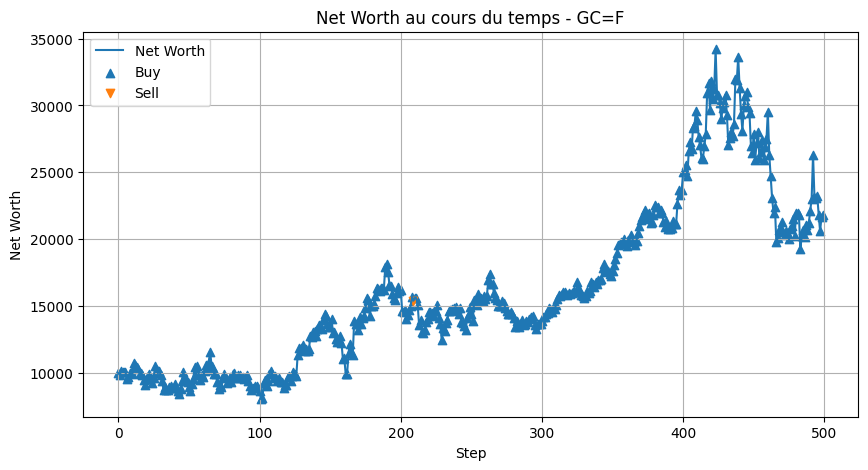

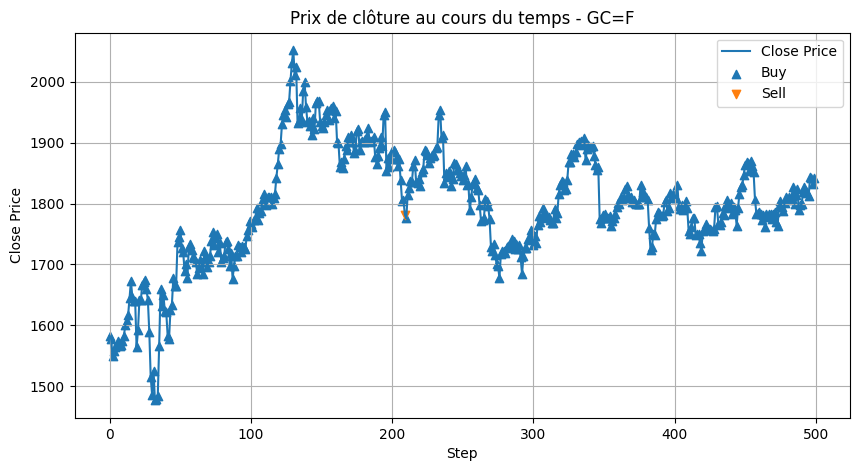

In [12]:
import DDPG
import importlib
importlib.reload(DDPG)
from DDPG import DDPGAgent

train_env = CommodityTradingEnv(commodity_data=training_data)
test_env = CommodityTradingEnv(commodity_data=test_data)

# Dimensions de l'espace d'observation et d'action
state_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.shape[0]

# Instanciation de l'agent DDPG
agent = DDPGAgent(train_env, state_dim, action_dim)

# Entraînement de l'agent sur un certain nombre d'épisodes
rewards = agent.train(num_episodes=1, max_steps_per_episode=train_env.max_steps, noise_scale=0.4)
cumulative_return, std, sharpe = agent.test(env=test_env)
agent.evaluate_strategy(test_env)

/tmp/ipykernel_4707/2151754817.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.actor.load_state_dict(torch.load("./models/best_ddpg.pth"))
/tmp/ipykernel_4707/1957

Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1

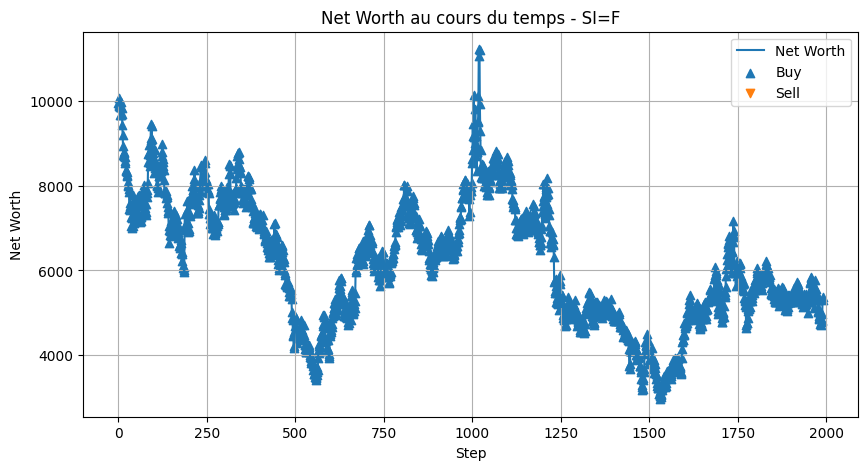

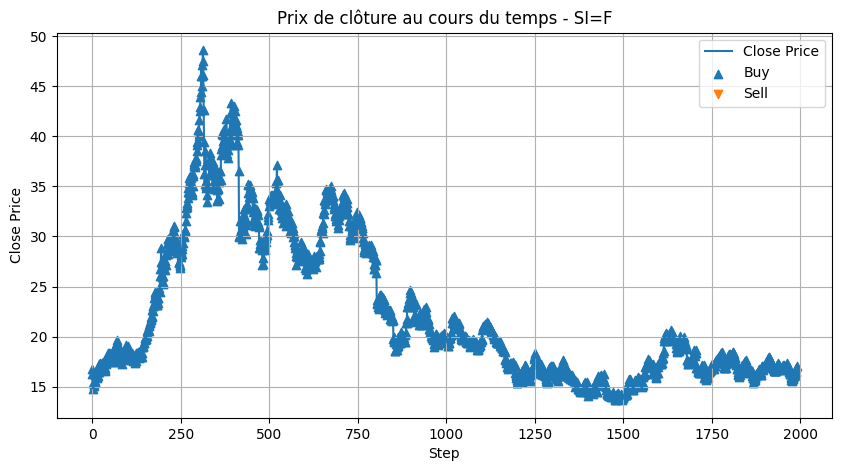

In [13]:
import torch
agent.actor.load_state_dict(torch.load("./models/best_ddpg.pth"))
agent.actor.eval()  # optionnel mais bon style


def trading_strategy(agent, env, ticker="GC=F", max_steps=500):
    """
    Fait tourner l'agent dans l'env pour `max_steps` (ou jusqu'à done),
    enregistre :
      - net_worth au cours du temps
      - le prix 'Close' du ticker
      - les décisions de trading (Buy, Sell, Hold)
    Produit ensuite 2 graphiques :
      1) Evolution du Net Worth
      2) Evolution du prix du ticker + positions
    """
    # On s'assure que le ticker demandé existe dans l'environnement
    if ticker not in env.tickers:
        raise ValueError(f"Ticker {ticker} pas présent dans l'environnement.")

    # Reset de l'env
    state, _ = env.reset()
    done = False
    step = 0
    
    net_worths = []
    close_prices = []
    actions_list = []

    while not done and step < max_steps:
        # L'agent choisit une action
        action = agent.predict(state)
        print(f"Action {action}")
        
        # Environnement avance d'un pas
        next_state, reward, done, _, _ = env.step(action)
        
        # On enregistre les variables utiles
        net_worths.append(env.net_worth)
        
        # Prix close du ticker courant (à la step courante)
        current_price = float(env.commodity_data[ticker].iloc[env.current_step]['Close'])
        close_prices.append(current_price)
        
        # On garde juste l'action associée à ce ticker (index dans agent.action_dim)
        # Comme l'agent sort un array d'actions pour chaque ticker, on trouve
        # la position du ticker pour récupérer la composante correspondante.
        ticker_index = env.tickers.index(ticker)
        actions_list.append(action[ticker_index])
        
        # Prépare pour la prochaine itération
        state = next_state
        step += 1

    # -----------------------------------------
    # 1) Graphe de l'évolution du net_worth
    # -----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(net_worths, label="Net Worth")

    # Indices Buy & Sell
    buy_indices = [i for i, a in enumerate(actions_list) if a > 0]
    sell_indices = [i for i, a in enumerate(actions_list) if a < 0]

    # Marqueurs Buy / Sell sur le net worth
    plt.scatter(buy_indices, [net_worths[i] for i in buy_indices],
                marker="^", label="Buy")
    plt.scatter(sell_indices, [net_worths[i] for i in sell_indices],
                marker="v", label="Sell")
    
    plt.title(f"Net Worth au cours du temps - {ticker}")
    plt.xlabel("Step")
    plt.ylabel("Net Worth")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # -----------------------------------------
    # 2) Graphe de l'évolution du prix Close
    # -----------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices, label="Close Price")

    # Marqueurs Buy / Sell sur le prix
    plt.scatter(buy_indices, [close_prices[i] for i in buy_indices],
                marker="^", label="Buy")
    plt.scatter(sell_indices, [close_prices[i] for i in sell_indices],
                marker="v", label="Sell")
    
    plt.title(f"Prix de clôture au cours du temps - {ticker}")
    plt.xlabel("Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# Crude Oil : CL=F
# Natural Gas : NG=F
# Gold : GC=F
# Silver : SI=F
# Copper : HG=F
test_env = CommodityTradingEnv(commodity_data=training_data)  # pour voir si stratégie apprise est cohérente

trading_strategy(agent, test_env, ticker="SI=F", max_steps=5000)


/tmp/ipykernel_4707/2519465121.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.actor.load_state_dict(torch.load("./models/best_ddpg.pth"))
/tmp/ipykernel_4707/1957

<class 'DDPG.Actor'>
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1.  1.]
Action [-1.  1.  1.  1

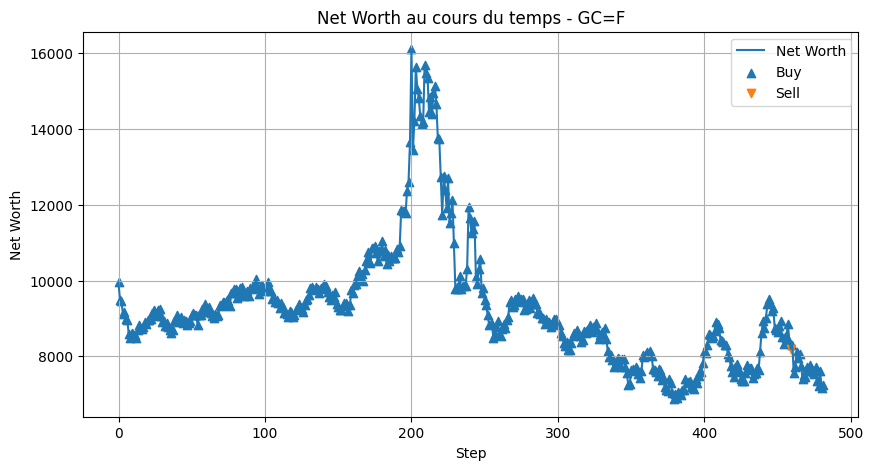

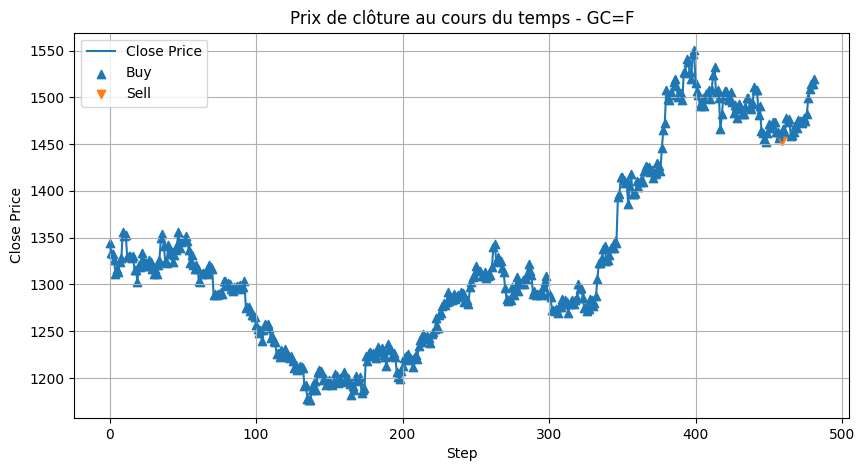

In [14]:
test_env = CommodityTradingEnv(commodity_data=validation_data)

# Charger le meilleur agent
agent.actor.load_state_dict(torch.load("./models/best_ddpg.pth"))

print(type(agent.actor))


# Lancer la stratégie
trading_strategy(agent, test_env, ticker="GC=F", max_steps=10000)

## FinRL tests

In [15]:
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import torch
import matplotlib.pyplot as plt


# Dimensions de l'espace d'action
n_actions = train_env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialisation de l'agent DDPG
model = DDPG(
    "MlpPolicy",
    train_env,
    action_noise=action_noise,
    verbose=1,
    tensorboard_log="./ddpg_tensorboard/"
)

model.learn(total_timesteps=10000)  # Tu peux adapter
model.save("./models/ddpg_sb3")

# Environnement de test sur données de train (ou test_env si tu veux)
test_env = CommodityTradingEnv(commodity_data=training_data)

# Recharger le modèle
loaded_model = DDPG.load("./models/ddpg_sb3")



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_tensorboard/DDPG_3


/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.99e+03 |
|    ep_rew_mean     | -7.7e+05 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 256      |
|    time_elapsed    | 31       |
|    total_timesteps | 7964     |
| train/             |          |
|    actor_loss      | 7.95e+03 |
|    critic_loss     | 1.86e+07 |
|    learning_rate   | 0.001    |
|    n_updates       | 7863     |
---------------------------------


Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1

/tmp/ipykernel_4707/1957984784.py:88: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_prices[ticker] = float(self.commodity_data[ticker].iloc[self.current_step]['Close'])
/tmp/ipykernel_4707/4233557923.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_price = float(env.commodity_data[ticker].iloc[env.current_step]['Close'])


Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1. -1. -1. -1.]
Action [ 1. -1

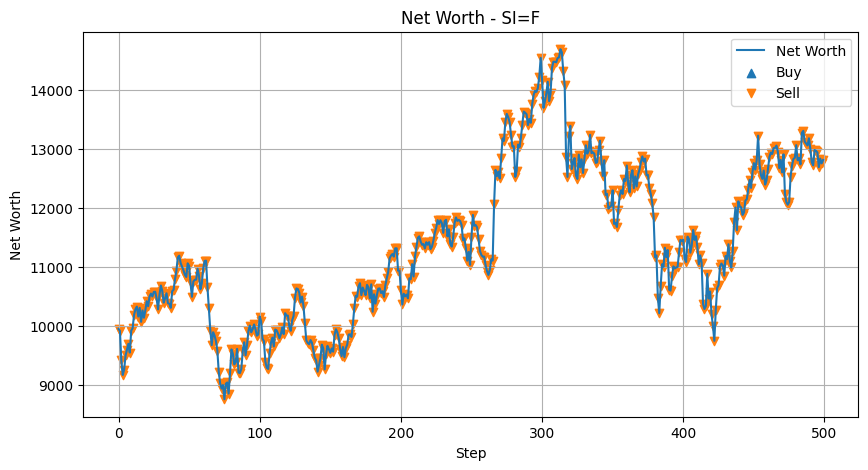

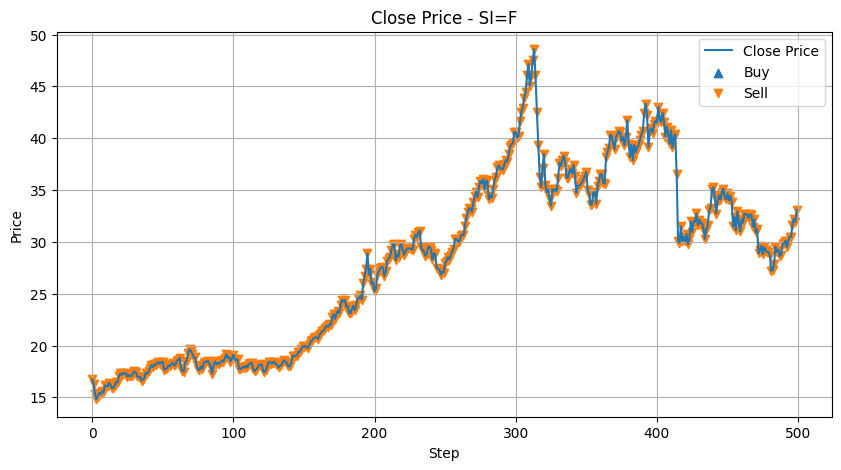

In [16]:
def visualize_trading_strategy(model, env, ticker="GC=F", max_steps=500):
    state, _ = env.reset()
    done = False
    step = 0
    net_worths = []
    close_prices = []
    actions_list = []

    if ticker not in env.tickers:
        raise ValueError(f"Ticker {ticker} not in environment.")
    ticker_index = env.tickers.index(ticker)

    while not done and step < max_steps:
        action, _ = model.predict(state, deterministic=True)
        print(f"Action {action}")
        next_state, reward, done, _, _ = env.step(action)

        net_worths.append(env.net_worth)
        close_price = float(env.commodity_data[ticker].iloc[env.current_step]['Close'])
        close_prices.append(close_price)
        actions_list.append(action[ticker_index])

        state = next_state
        step += 1

    # Indices Buy/Sell
    buy_indices = [i for i, a in enumerate(actions_list) if a > 0]
    sell_indices = [i for i, a in enumerate(actions_list) if a < 0]

    # Graphe Net Worth
    plt.figure(figsize=(10, 5))
    plt.plot(net_worths, label="Net Worth")
    plt.scatter(buy_indices, [net_worths[i] for i in buy_indices], marker="^", label="Buy")
    plt.scatter(sell_indices, [net_worths[i] for i in sell_indices], marker="v", label="Sell")
    plt.title(f"Net Worth - {ticker}")
    plt.xlabel("Step")
    plt.ylabel("Net Worth")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Graphe prix
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices, label="Close Price")
    plt.scatter(buy_indices, [close_prices[i] for i in buy_indices], marker="^", label="Buy")
    plt.scatter(sell_indices, [close_prices[i] for i in sell_indices], marker="v", label="Sell")
    plt.title(f"Close Price - {ticker}")
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_trading_strategy(loaded_model, test_env, ticker="SI=F", max_steps=500)
